# Neura Networks Classifier

We have choose to use the MLPClassifier from Sklearn as Neural Network implememtation, to have a simpler interface w.r.t. other libraries, and because we don't need to have the back-end functionalities imported with the Graph-Based-Computation libraries (like Tensorflow and Pytorch).

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from classification_utils import *
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statistics
import pickle
from sklearn.metrics import RocCurveDisplay

## Load Data

In [2]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903,0.232481
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495,0.167568
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008,0.392850
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619,0.120737


In [4]:
data.describe()

,bot,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,0.531456,5148.794751,67.100135,15.045892,0.031045,0.347537,0.101921,0.001967,0.023941,0.084282,0.365569,0.385430,98.347409,361.956697,1.011612
std,0.499031,18496.606420,12.755296,2.454106,0.053379,0.343735,0.093837,0.007796,0.068508,0.109623,0.408441,0.390787,329.248000,626.207734,1.412183
min,0.000000,0.000000,32.500000,9.644166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
25%,0.000000,53.000000,59.686796,13.553296,0.000000,0.010260,0.045455,0.000000,0.000000,0.017751,0.136692,0.119116,0.022901,0.151796,0.136059
50%,1.000000,57.000000,65.340909,14.694444,0.005109,0.303797,0.073394,0.000000,0.000000,0.045752,0.230747,0.268594,0.096931,0.437106,0.312150
75%,1.000000,2041.000000,74.254999,16.772205,0.037445,0.500000,0.128810,0.000000,0.000000,0.088862,0.451218,0.491767,74.499524,533.013057,1.462435
max,1.000000,399555.000000,104.449541,22.000000,0.287760,1.726592,0.478261,0.044444,0.333767,0.529903,2.183383,1.723913,14432.000000,5442.443396,9.161105


In [5]:
data.isnull().values.any()

False

Plot the number of users for each lang to see that the **Lang** features is not well distributed, so as we will se can be removed.

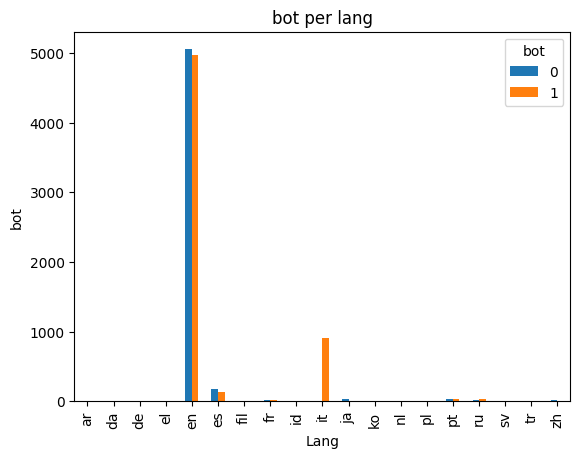

In [6]:
plot_lang_hist(data)

Apply the **One-Hot-Encoding** of **Lang** feature

In [7]:
data = data.join(pd.get_dummies(data["lang"]))

In [8]:
#data.drop(columns=['created_at'])

In [9]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


Apply standard scaler trasformation

In [10]:
scaler = StandardScaler()
scaled_train_set = scaler.fit_transform(train_set.values)
scaled_test_set = scaler.transform(test_set.values)

Apply grid search over some parameters:
- **hidden_layer_sizes**: The size of each hidden layer, the first and last are inferred by the dimensionality of the input.
- **hidden_layer_sizes**: The learning rate value of the SGD optimizer.
- **momentum**: The momentum value of the SGD optimizer.

In [11]:
param_grid = dict(
    hidden_layer_sizes = [[16, 8], [32, 16, 8]],
    learning_rate_init = [0.001, 0.01, 0.1],
    momentum = [0.1, 0.5, 0.8]
)

print(param_grid)

grid = GridSearchCV(
    MLPClassifier(random_state = 8, activation='relu', max_iter = 100),
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1
)

grid_result = grid.fit(scaled_train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'hidden_layer_sizes': [[16, 8], [32, 16, 8]], 'learning_rate_init': [0.001, 0.01, 0.1], 'momentum': [0.1, 0.5, 0.8]}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best: 0.834264 using {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.1}
0.833147 (0.004290) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.1}
0.833147 (0.004290) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.5}
0.833147 (0.004290) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.8}
0.834264 (0.007086) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.1}
0.834264 (0.007086) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.5}
0.834264 (0.007086) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.8}
0.817256 (0.016292) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.1, 'momentum': 0.1}
0.817256 (0.016292) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.1, 'momentum': 0.5}
0.817256 (0.016292) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init

In [12]:
nn = grid.best_estimator_

## Print Metrics

In [13]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [14]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8600869025450031
Accuracy test set  0.838401390095569
Precision train set  0.886012273948527
Recall train set  0.8600869025450031
F1 score train set  0.8562970755612639
Support train set  (array([0.98964114, 0.7946562 ]), array([0.70879703, 0.99345947]), array([0.82599969, 0.88300633]), array([3774, 4281], dtype=int64))


In [15]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.96      0.68      0.80      1618
         >50       0.78      0.98      0.87      1835

    accuracy                           0.84      3453
   macro avg       0.87      0.83      0.83      3453
weighted avg       0.86      0.84      0.83      3453



### Confusion Matrix

C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


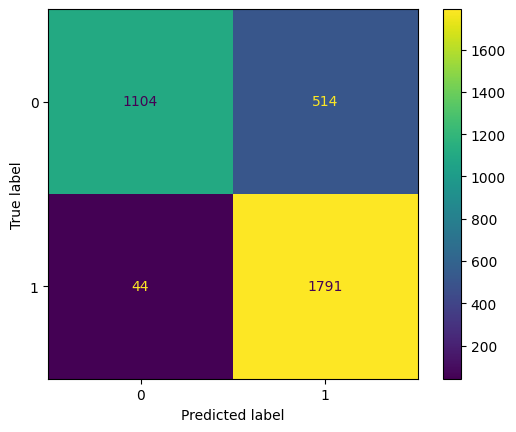

In [16]:
plot_confusion_matrix(nn, scaled_test_set, test_label)
plt.show()

### ROC-Curve

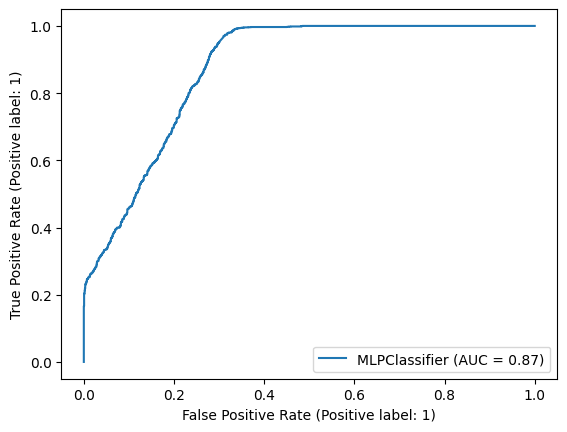

In [17]:
RocCurveDisplay.from_estimator(nn, scaled_test_set, test_label)
plt.show()

### PCA Blobs

In [18]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

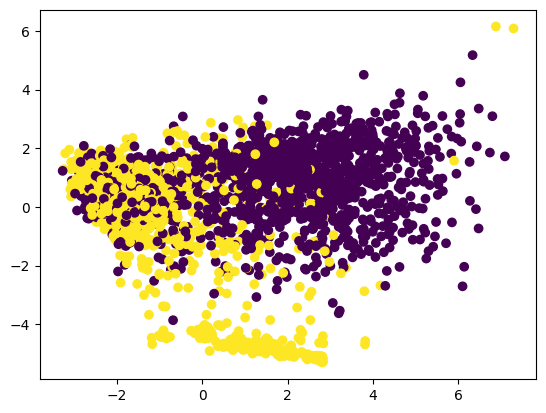

In [19]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

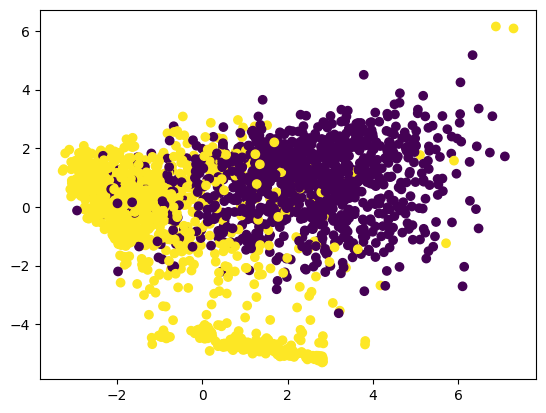

In [20]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [21]:
with open("../models_checkpoints/nn_lang.bin", "wb") as f:
    pickle.dump(nn, f)

## Redo without **Lang** Feature

Re-train the model, with model evaluation without **Lang** feature to see if the accuracy change, we will see that the lang feature is not so important as premise.

In [22]:
for lang in data.lang.unique():
    del train_set[lang]
    del test_set[lang]

In [23]:
train_set.head()

,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2351467735,1550743978,53,46.951807,9.884337,0.000000,0.387952,0.038554,0.0,0.0,0.043373,0.203696,0.257551,0.089157,1.095116,0.249622
347587058,1470273787,53,78.573190,17.079357,0.005109,0.000000,0.000000,0.0,0.0,0.013137,0.127206,0.098533,0.013137,0.122918,0.099408
1129895606,1517367911,53,55.833333,12.611111,0.000000,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
269193431,1458547948,9105,60.301689,12.949343,0.051782,0.505816,0.036398,0.0,0.0,0.160600,0.495103,0.661001,156.657786,1127.737572,1.775016
2368471386,1551683554,54,63.949580,15.117647,0.000000,0.352941,0.084034,0.0,0.0,0.050420,0.254332,0.281797,0.016807,0.128547,0.123115


In [24]:
scaler = StandardScaler()

scaled_train_set = scaler.fit_transform(train_set.values)
scaled_test_set = scaler.transform(test_set.values)

In [25]:
param_grid = dict(
    hidden_layer_sizes = [[16, 8], [32, 16, 8]],
    learning_rate_init = [0.001, 0.01, 0.1],
    momentum = [0.1, 0.5, 0.8]
)

print(param_grid)

grid = GridSearchCV(
    MLPClassifier(random_state = 8, activation='relu', max_iter = 100),
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1
)

grid_result = grid.fit(scaled_train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'hidden_layer_sizes': [[16, 8], [32, 16, 8]], 'learning_rate_init': [0.001, 0.01, 0.1], 'momentum': [0.1, 0.5, 0.8]}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best: 0.837120 using {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.1}
0.833147 (0.002933) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.1}
0.833147 (0.002933) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.5}
0.833147 (0.002933) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.001, 'momentum': 0.8}
0.837120 (0.008212) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.1}
0.837120 (0.008212) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.5}
0.837120 (0.008212) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.01, 'momentum': 0.8}
0.831657 (0.005802) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.1, 'momentum': 0.1}
0.831657 (0.005802) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init': 0.1, 'momentum': 0.5}
0.831657 (0.005802) with: {'hidden_layer_sizes': [16, 8], 'learning_rate_init

In [26]:
nn = grid.best_estimator_

## Print Metrics

In [27]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [28]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8608317815021725
Accuracy test set  0.8389805965826818
Precision train set  0.8807496533043409
Recall train set  0.8608317815021725
F1 score train set  0.8577460208863219
Support train set  (array([0.97022333, 0.80187237]), array([0.72522523, 0.98037842]), array([0.83002274, 0.88218602]), array([3774, 4281], dtype=int64))


In [29]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.94      0.70      0.80      1618
         >50       0.78      0.96      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.86      0.83      0.83      3453
weighted avg       0.86      0.84      0.84      3453



### Confusion Matrix

C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


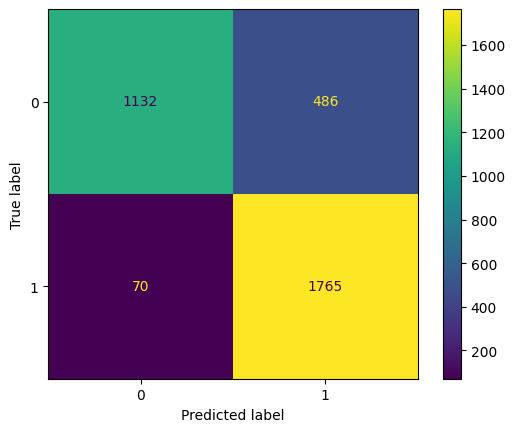

In [30]:
plot_confusion_matrix(nn, scaled_test_set, test_label)
plt.show()

### ROC-Curve

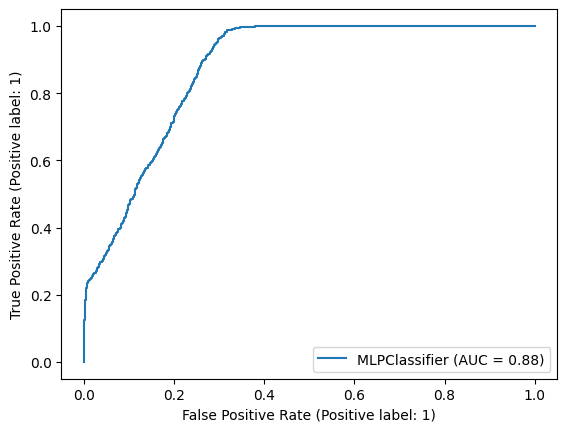

In [31]:
RocCurveDisplay.from_estimator(nn, scaled_test_set, test_label)
plt.show()

### PCA Blobs

In [32]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

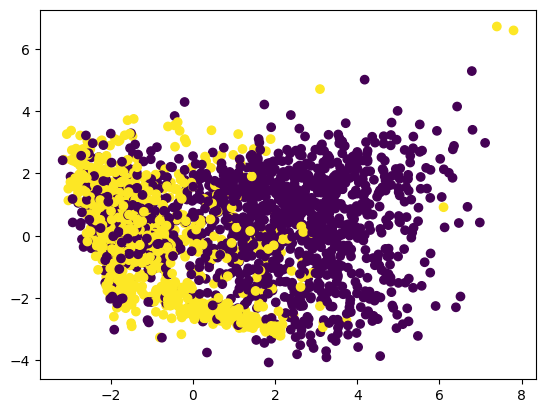

In [33]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

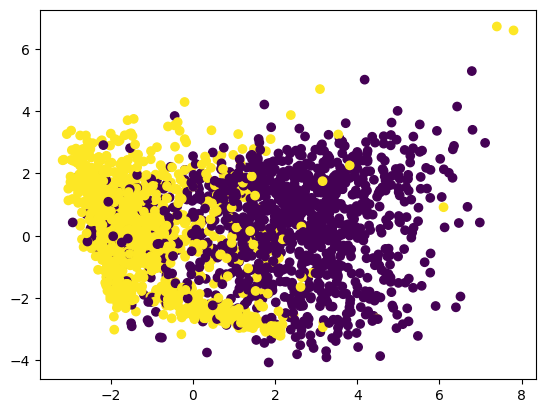

In [34]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [35]:
with open("../models_checkpoints/nn_no_lang.bin", "wb") as f:
    pickle.dump(nn, f)